<a href="https://colab.research.google.com/github/hernss/MachineLearningCourse/blob/main/07_milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check GPU (Testla T4 needed)
!nvidia-smi

Thu Feb 23 21:24:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import helper functions

In [2]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


from helper_functions import unzip_data, walk_through_dir, compare_historys, plot_loss_curves, create_tensorboard_callback

--2023-02-23 21:24:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-23 21:24:09 (68.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Use tensorflow dataset to download data

In [3]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [4]:
datasets_list = tfds.list_builders() # Get all datasets available
print("food101" in datasets_list)

True


In [5]:
# Load food101 dataset
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteM4JTOW/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteM4JTOW/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Features of Food101 from TFDS

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class name
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Explorer the Food101 Dataset

* Class names
* The shape of our input data
* The datatype 
* What labels llos like
* Do label match with class name


In [8]:
# Take one sample of train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Putput info for ourn sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target Class from Food101: {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target Class from Food101: 90
  Class name (str form): spaghetti_bolognese
  


In [10]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from Tensorflow Datasets

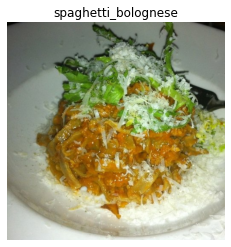

In [15]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing function for our data


In [16]:
# Make a function for preprocessing images

def preprocessing_img(image, label, img_shape=224):
  """ 
  Convert image datatype from uint8 -> float32
  and reshape image to [img_shape, img_shape, 3]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [18]:
# Preprocess a sinle image

preprocessed_img = preprocessing_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}\nDataype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}\nDataype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3)
Dataype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.586735   12.586735    6.586735  ]
  [11.714286   12.714286    6.714286  ]
  [ 8.857142    9.857142    4.8571424 ]
  ...
  [20.714308   11.142836    1.2857144 ]
  [20.668371   10.668372    0.        ]
  [21.         11.          0.        ]]

 [[ 2.3571415   3.3571415   0.1428566 ]
  [ 3.1530607   4.153061    0.07653028]
  [ 3.0561223   4.0561223   0.        ]
  ...
  [26.071407   18.071407    7.0714073 ]
  [24.785702   14.785702    4.7857018 ]
  [22.499966   12.499966    2.4999657 ]]]...,
Shape: (224, 224, 3)
Dataype: <dtype: 'float32'>


In [19]:
# Map preprocessing function to trainin
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [22]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

* TensorBoard Callback
* ModelCheckpoint Callback

In [24]:
from helper_functions import create_tensorboard_callback 

# Create model checkpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                              monitor="val_accuracy",
                                                              save_weights_only=True,
                                                              save_best_only=True,
                                                              verbose=0)


## Setup mix precision  training

In [25]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Create feature extraction model


In [30]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

# x = preprocessing.Rescaling(1.255)(inputs) # For ResNet50V2

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [34]:
# Checking layer dtype policy

for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [36]:
# Checking efficientnetb0 layer dtype policy

for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

# Fit the feature extraction model

In [39]:
history_0 = model.fit(train_data,
                      epochs=3,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_class"), model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_class/20230223-223353
Epoch 1/3
2368/2368 [==============================] - 238s 93ms/step - loss: 1.7182 - accuracy: 0.5827 - val_loss: 1.1354 - val_accuracy: 0.6912
Epoch 2/3
2368/2368 [==============================] - 201s 84ms/step - loss: 1.1993 - accuracy: 0.6895 - val_loss: 1.0404 - val_accuracy: 0.7185
Epoch 3/3
2368/2368 [==============================] - 197s 82ms/step - loss: 1.0546 - accuracy: 0.7237 - val_loss: 0.9837 - val_accuracy: 0.7336


In [40]:
results_feature_extraction = model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 0.9928 - accuracy: 0.7317


[0.9927735924720764, 0.7317227721214294]

In [41]:
# Save the model

model.save("feature_extraction_model_saved")

TypeError: ignored

In [42]:
# Load model from disk
loaded_model = tf.keras.models.load_model("feature_extraction_model_saved")

ValueError: ignored

# Preparing our model's layers for fine-tuning

In [43]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-02-23 22:50:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c16::80, 2a00:1450:4013:c14::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  15.0MB/s    in 1.1s    

2023-02-23 22:50:40 (15.0 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [44]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [45]:
# Load and evaluate downloaded GS model

model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

model.evaluate(test_data)

790/790 [==============================] - 65s 80ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880988836288452, 0.7066138386726379]

In [46]:
# Get a summary of the downloaded model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [47]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)

for layer in model.layers:
  layer.trainable = True

In [48]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in model.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)


input_layer float32 <Policy "float32">
efficientnetb0 float32 <Policy "mixed_float16">
pooling_layer float32 <Policy "mixed_float16">
dense float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">


In [54]:
import tensorflow as tf

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=0)

In [56]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [57]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier

history_1 = model.fit(train_data,
                      epochs=100,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_class_v2"), checkpoint_callback, earlystop_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_class_v2/20230223-230802
Epoch 1/100
2368/2368 [==============================] - 469s 177ms/step - loss: 0.9224 - accuracy: 0.7540 - val_loss: 0.8053 - val_accuracy: 0.7765
Epoch 2/100
2368/2368 [==============================] - 419s 176ms/step - loss: 0.5794 - accuracy: 0.8402 - val_loss: 0.7689 - val_accuracy: 0.7887
Epoch 3/100
2368/2368 [==============================] - 409s 171ms/step - loss: 0.3309 - accuracy: 0.9074 - val_loss: 0.8380 - val_accuracy: 0.7815
Epoch 4/100
2368/2368 [==============================] - 409s 171ms/step - loss: 0.1754 - accuracy: 0.9484 - val_loss: 0.9764 - val_accuracy: 0.7699
Epoch 5/100
2368/2368 [==============================] - 408s 171ms/step - loss: 0.1100 - accuracy: 0.9660 - val_loss: 1.0965 - val_accuracy: 0.7715


In [58]:
model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 1.1130 - accuracy: 0.7685


[1.1129623651504517, 0.76851487159729]